In [1]:
import os

import numpy as np
import scipy.misc
from sklearn.metrics import *
from sklearn.model_selection import *
from sklearn.preprocessing import *
import tensorflow as tf
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
tf.logging.set_verbosity(tf.logging.INFO)

In [3]:
RED = 0
GREEN = 1
BLUE = 2

In [4]:
def determine_color_from_filename(filename):
    if 'blue' in filename.lower():
        return BLUE
    if 'green' in filename.lower():
        return GREEN
    return RED

def to_display_name(value):
    if value == BLUE:
        return 'blue'
    if value == GREEN:
        return 'green'
    return 'red'

In [5]:
raw_X = []
raw_y = []
for folder_path, folders, filenames in os.walk('data/input'):
    for filename in filenames:
        filepath = os.path.join(folder_path, filename)
        image = Image.open(filepath).convert('RGB')
        image = np.array(image)
        raw_X.append(image)
        raw_y.append(determine_color_from_filename(filename))

X = np.array(raw_X, dtype='float32')
y = np.array(raw_y, dtype='int32')

In [6]:
print('X.shape: ', X.shape)
print('y.shape: ', y.shape)

X.shape:  (470, 64, 64, 3)
y.shape:  (470,)


In [7]:
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size = 0.2)

In [8]:
print('X_train.shape: ', X_train.shape)
print('X_cv.shape: ', X_cv.shape)
print('y_train.shape: ', y_train.shape)
print('y_cv.shape: ', y_cv.shape)

X_train.shape:  (376, 64, 64, 3)
X_cv.shape:  (94, 64, 64, 3)
y_train.shape:  (376,)
y_cv.shape:  (94,)


Begin Tensorflow Code

In [9]:
feature_columns = tf.contrib.learn.infer_real_valued_columns_from_input(X_train)

In [10]:
classifier = tf.contrib.learn.DNNClassifier(feature_columns=feature_columns,
                                            hidden_units=[16],
                                            enable_centered_bias=True,
                                            n_classes=3)


INFO:tensorflow:Using config: {'tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, 'keep_checkpoint_every_n_hours': 10000, 'save_checkpoints_secs': 600, 'evaluation_master': '', 'master': '', '_is_chief': True, 'tf_random_seed': None, 'num_ps_replicas': 0, 'keep_checkpoint_max': 5, 'cluster_spec': None, 'task': 0, 'save_summary_steps': 100, '_job_name': None}


In [11]:
classifier.fit(X_train, y_train, batch_size=100, steps=200)

INFO:tensorflow:Setting feature info to TensorSignature(dtype=tf.float32, shape=TensorShape([Dimension(None), Dimension(64), Dimension(64), Dimension(3)]), is_sparse=False)
INFO:tensorflow:Setting targets info to TensorSignature(dtype=tf.int32, shape=TensorShape([Dimension(None)]), is_sparse=False)
INFO:tensorflow:Transforming feature_column _RealValuedColumn(column_name='', dimension=12288, default_value=None, dtype=tf.float32, normalizer=None)
INFO:tensorflow:Create CheckpointSaverHook
INFO:tensorflow:loss = 135.818, step = 1
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmps9rasthb/model.ckpt.
INFO:tensorflow:loss = 0.0, step = 101
INFO:tensorflow:Saving checkpoints for 200 into /tmp/tmps9rasthb/model.ckpt.
INFO:tensorflow:Loss for final step: 0.0.


Estimator(params={'num_ps_replicas': 0, 'weight_column_name': None, 'enable_centered_bias': True, 'dropout': None, 'n_classes': 3, 'hidden_units': [16], 'gradient_clip_norm': None, 'optimizer': 'Adagrad', 'feature_columns': [_RealValuedColumn(column_name='', dimension=12288, default_value=None, dtype=tf.float32, normalizer=None)], 'activation_fn': <function relu at 0x7fe3df0020d0>})

In [12]:
y_cv_pred = classifier.predict(X_cv, as_iterable=True)
y_cv_pred = np.array([i[0] for i in y_cv_pred])

INFO:tensorflow:Transforming feature_column _RealValuedColumn(column_name='', dimension=12288, default_value=None, dtype=tf.float32, normalizer=None)
INFO:tensorflow:Loading model from checkpoint: /tmp/tmps9rasthb/model.ckpt-200-?????-of-00001.


In [13]:
y_cv_pred_proba = classifier.predict_proba(X_cv, as_iterable=True)
y_cv_pred_proba = np.array([i for i in y_cv_pred_proba])

INFO:tensorflow:Transforming feature_column _RealValuedColumn(column_name='', dimension=12288, default_value=None, dtype=tf.float32, normalizer=None)
INFO:tensorflow:Loading model from checkpoint: /tmp/tmps9rasthb/model.ckpt-200-?????-of-00001.


In [14]:
print('Accuracy score: ', accuracy_score(y_cv, y_cv_pred))

Accuracy score:  0.978723404255


In [15]:
print('Log loss: ', log_loss(y_true=y_cv, y_pred=y_cv_pred_proba, labels=[0,1,2]))

Log loss:  0.73486758293


## Visualize the correct and wrong examples.

In [16]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 14}
plt.rc('font', **font)

def get_info(truth, prediction):
    if truth == prediction:
        return to_display_name(truth)
    else:
        return 'Exp: {0} Act: {1}'.format(to_display_name(truth), to_display_name(prediction))


/usr/local/lib/python3.4/dist-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


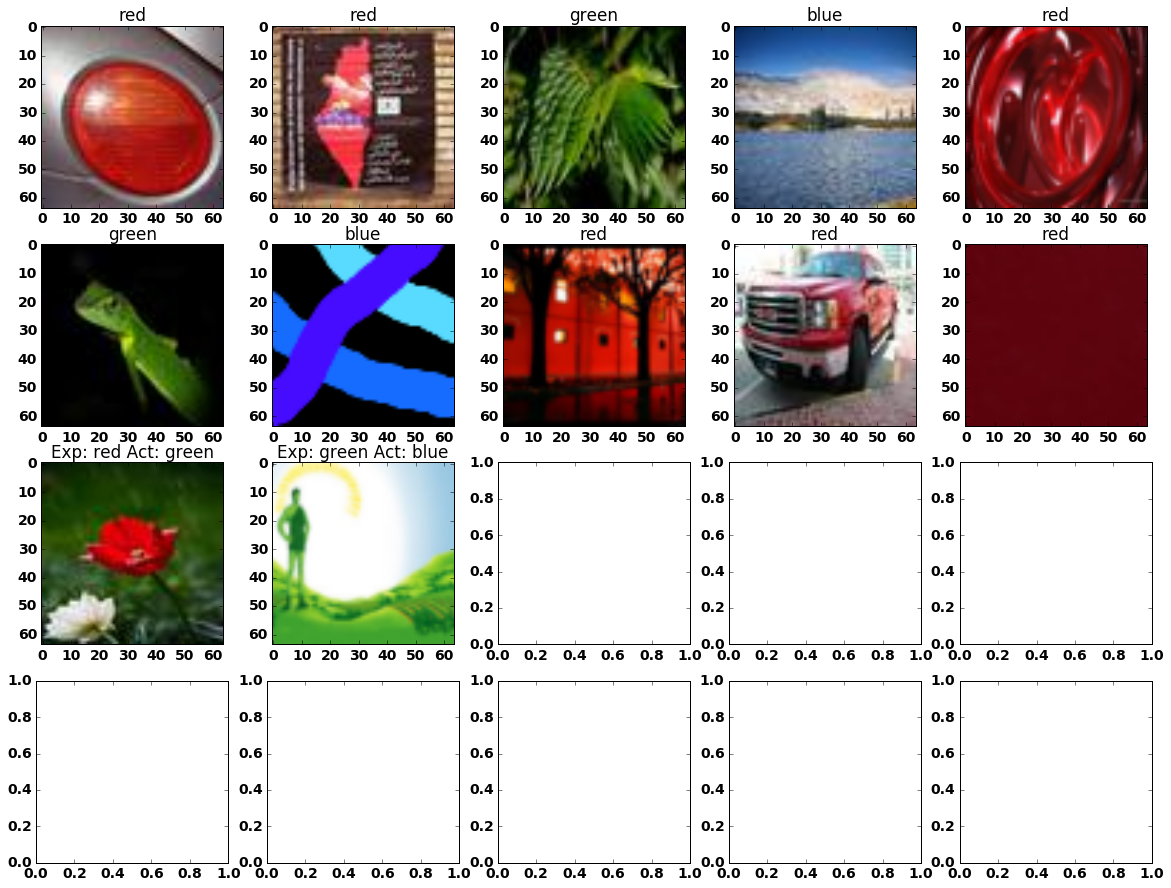

In [17]:
n = 4
m = 5
fig, axarr = plt.subplots(n, m)
fig.set_figwidth(20)
fig.set_figheight(15)

# Plot correct ones.
img_id = 0
for i in [0, 1]:
    for j in range(m):
        while img_id < y_cv.shape[0] and y_cv[img_id] != y_cv_pred[img_id]:
            img_id += 1
        if img_id < y_cv.shape[0] and y_cv[img_id] == y_cv_pred[img_id]:
            axarr[i,j].set_title(get_info(y_cv[img_id], y_cv_pred[img_id]))
            axarr[i,j].imshow(Image.fromarray(np.uint8(X_cv[img_id])))
            img_id += 1

# Plot wrong ones.
img_id = 0
for i in [2, 3]:
    for j in range(m):
        while img_id < y_cv.shape[0] and y_cv[img_id] == y_cv_pred[img_id]:
            img_id += 1
        if img_id < y_cv.shape[0] and y_cv[img_id] != y_cv_pred[img_id]:
            axarr[i,j].set_title(get_info(y_cv[img_id], y_cv_pred[img_id]))
            axarr[i,j].imshow(Image.fromarray(np.uint8(X_cv[img_id])))
            img_id += 1